<a href="https://colab.research.google.com/github/NataliaGoszcz/PRA1week/blob/main/Assignment_Week3_CosmologyFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
try:
  import getdist
except:
  !pip install getdist
  import getdist

# Load required packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate

# import pylab
import getdist, IPython, time
from numpy import random

# from IPython.display import Image
from getdist import plots, MCSamples, loadMCSamples

# just for printing! calculations should be performed with machine precision
%precision 3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 826.1/826.1 kB 5.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for getdist: filename=getdist-1.4.7-py3-none-any.whl size=810432 sha256=961cfea72b98123ddc7135138d2bb5ee91d1370e27c20baf61bae9108bd7208c
  Stored in directory: /root/.cache/pip/wheels/11/3e/8d/93c9494b4587d95165f805b376a4c7ed3ae670eb3cf7397389
Successfully built getdist


'%.3f'

# Defining the functions and creating the model


In [ ]:
# defining the Hubble rate function
def Hubble(z, Omega_L, Omega_M, h):
    H0 = 100 * h
    Omega_k = 1 - (Omega_L + Omega_M)
    H = H0 * (Omega_L + Omega_M * (1+z)**3 + Omega_k * (1+z)**2)**0.5 #H units are km/s/Mpc
    return H

In [ ]:
# speed of light in units of km/s
c = 3* 10**5

# defining D(z)
def D(z, h, Omega_L, Omega_M):
     H0 = 100 * h
     d = H0 * integrate.quad(lambda x: 1/Hubble(x, Omega_L, Omega_M, h), 0, z)[0]
     return d

# defining the luminosity distance function
def dL(z, h,  Omega_L, Omega_M):
    Omega_k = 1 - ( Omega_L + Omega_M)
    H0 = 100 * h
    A = (c/H0)*(1+z)
    if Omega_k > 0:
      dl = A * (1/(Omega_k)**0.5)* np.sinh((Omega_k)**0.5 * D(z, h, Omega_L, Omega_M))
    elif Omega_k == 0:
      dl = A * D(z, h, Omega_L, Omega_M)
    else:
      dl = A * (1/(-Omega_k)**0.5)* np.sin((-Omega_k)**0.5 * D(z, h, Omega_L, Omega_M))
    return dl # luminosity distance is in Mpc here
# checking if it works:
print(dL(1.5, 0.7, 0.7, 0.3))

# defining the distance modulus mu
def mu(z, h, Omega_L, Omega_M):
    m = 5* np.log10(dL(z, h,  Omega_L, Omega_M)/(10**(-5))) #last number due to 10pc = 10 * 10^(-6)Mpc = 10^(-5)Mpc
    return m
# checking if it works:
print(mu(1.5, 0.7, 0.7, 0.3))

10917.192001792126
45.190554741776616


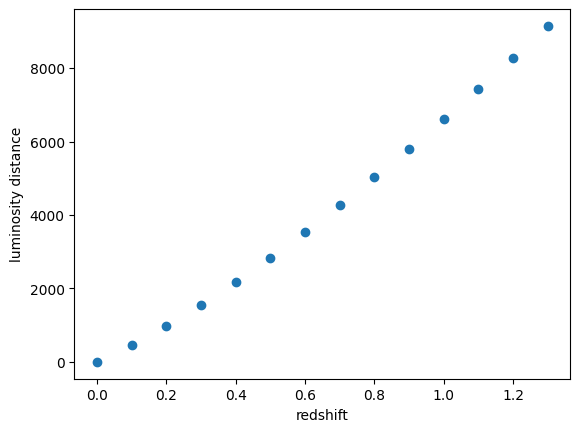

<ipython-input-3-3d091061304c>:27: RuntimeWarning: divide by zero encountered in log10
  m = 5* np.log10(dL(z, h,  Omega_L, Omega_M)/(10**(-5))) #last number due to 10pc = 10 * 10^(-6)Mpc = 10^(-5)Mpc


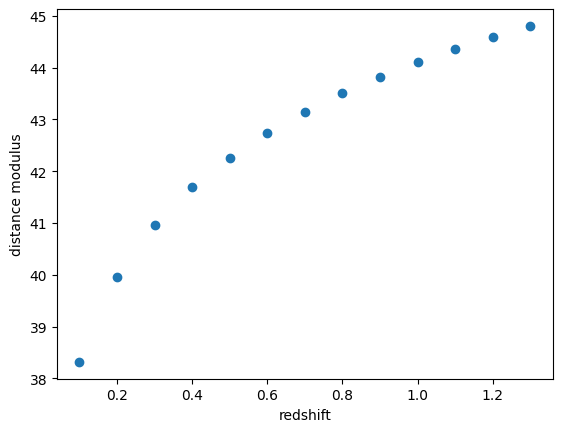

In [ ]:
# plotting the functions to see if they are what we expect
%matplotlib inline
# plot of the luminosity distance
zs = np.arange(0,1.4,0.1) # creates a range from 0 to 1.4 with steps of 0.1 for the redshift
dLs = []
for z in zs: # creates a list of dLs for each redshift z and chosen parameters
  dLs += [dL(z, 0.7, 0.7, 0.3)]

plt.scatter(zs, dLs)
plt.xlabel("redshift")
plt.ylabel("luminosity distance")
plt.show()

mus = []
for z in zs:
  mus += [mu(z, 0.7, 0.7, 0.3)]

plt.scatter(zs, mus)
plt.xlabel("redshift")
plt.ylabel("distance modulus")
plt.show()

# Importing and plotting the data

In [ ]:
dataloc = "http://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"
# Read in data as numpy array.
data = np.genfromtxt(dataloc)

In [ ]:
# Extract the redshifts (zs), distance modulus (mu_data) and magnitude estimated errors (err_mu_data)
zs = data.T[1] # redshifts
mu_data = data.T[2] # data
err_mu_data = data.T[3] # errors for each data point

<ipython-input-3-3d091061304c>:27: RuntimeWarning: divide by zero encountered in log10
  m = 5* np.log10(dL(z, h,  Omega_L, Omega_M)/(10**(-5))) #last number due to 10pc = 10 * 10^(-6)Mpc = 10^(-5)Mpc


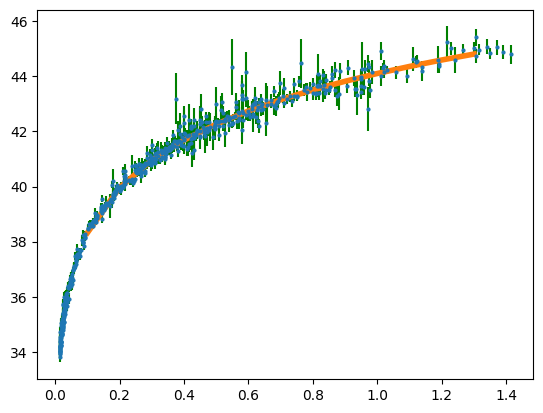

In [ ]:
%matplotlib inline
#the plot with the dots for data points:
plt.errorbar(zs, mu_data, yerr=err_mu_data, fmt = "o", markersize="2", ecolor="g")
#each observation has their own error

# comparing with the modeled distance modulus mu for chosen parameters:
zss = np.arange(0,1.4,0.1)
mus = []
for z in zss:
  mus += [mu(z, 0.7, 0.7, 0.3)]
plt.plot(zss, mus, linewidth=4)
plt.show()

# Markov-Chain Monte Carlo

In [ ]:
import random

# for recording the steps
h_tot = []
Omega_M_tot = []
Omega_L_tot = []

# decide the number of steps
N = 10000

# let's start with parameters:
h = 0.5
Omega_L = 0.5
Omega_M = 0.5

# calculate chi square for these old parameters and a varying redshift
chi2_tot_old = 0
for i in range(len(zs)):
    mu_mod = mu(zs[i], h, Omega_L, Omega_M)
    chi2old = (mu_mod - mu_data[i])**2 / (err_mu_data[i])**2
    chi2_tot_old += chi2old

# Now for the steps and new parameters
counter = 0
while (True):
  # introduce new parameters with gaussian distribution steps
  h_new = h + np.random.normal(0, 0.01)
  om_M_new = Omega_M + np.random.normal(0, 0.01)
  om_L_new = Omega_L + np.random.normal(0, 0.01)

  # now calculate the chi2 for new parameters
  chi2_tot_new = 0
  for i in range(len(zs)):
    mu_mod = mu(zs[i], h_new, om_L_new, om_M_new)
    chi2new = (mu_mod - mu_data[i])**2 / (err_mu_data[i])**2
    chi2_tot_new += chi2new

  # introducing a random number r between 0 and 1
  r = random.uniform(0,1)

  # calculating the likelihood ratio
  # due to it usually being very big (infinity) it's set to display 2 if that happens
  Lr = np.min((2., np.exp((chi2_tot_old - chi2_tot_new)/2)))

  #make an if statement for checking r<likelihood ratio
  if (om_M_new > 0.0) and (h_new > 0.0) and r < Lr:
    h = h_new
    Omega_L = om_L_new
    Omega_M = om_M_new
    chi2_tot_old = chi2_tot_new
    counter += 1

  h_tot.append(h)
  Omega_M_tot.append(Omega_M)
  Omega_L_tot.append(Omega_L)

  if counter >= N:
    break

#acceptance rate
ar = N / len(h_tot)
print("Acceptance rate is = ", ar)

<ipython-input-37-89d653cace76>:43: RuntimeWarning: overflow encountered in exp
  Lr = np.min((2., np.exp((chi2_tot_old - chi2_tot_new)/2)))


Acceptance rate is =  0.2633519435373433


In [ ]:
#record the steps
with open("MC_Chain_SNIa.txt", "w") as file:
  file.write("h \n")
  for item in h_tot:
    file.write(f"{item}\n")
  file.write("Omega L \n")
  for item in Omega_L_tot:
    file.write(f"{item}\n")
  file.write("Omage M \n")
  for item in Omega_M_tot:
    file.write(f"{item}\n")
file.close();

# Plotting the triangular graph and checking if Omega Lambda is non-zero

Removed no burn in
0.7  <  h  <  0.71  at  68 % CL
0.69  <  h  <  0.71  at  99 % CL
0.24  <  OmegaM  <  0.36  at  68 % CL
0.14  <  OmegaM  <  0.49  at  99 % CL
0.66  <  OmegaL  <  0.85  at  68 % CL
0.45  <  OmegaL  <  1.08  at  99 % CL
-0.21  <  OmegaK  <  0.1  at  68 % CL
-0.55  <  OmegaK  <  0.4  at  99 % CL




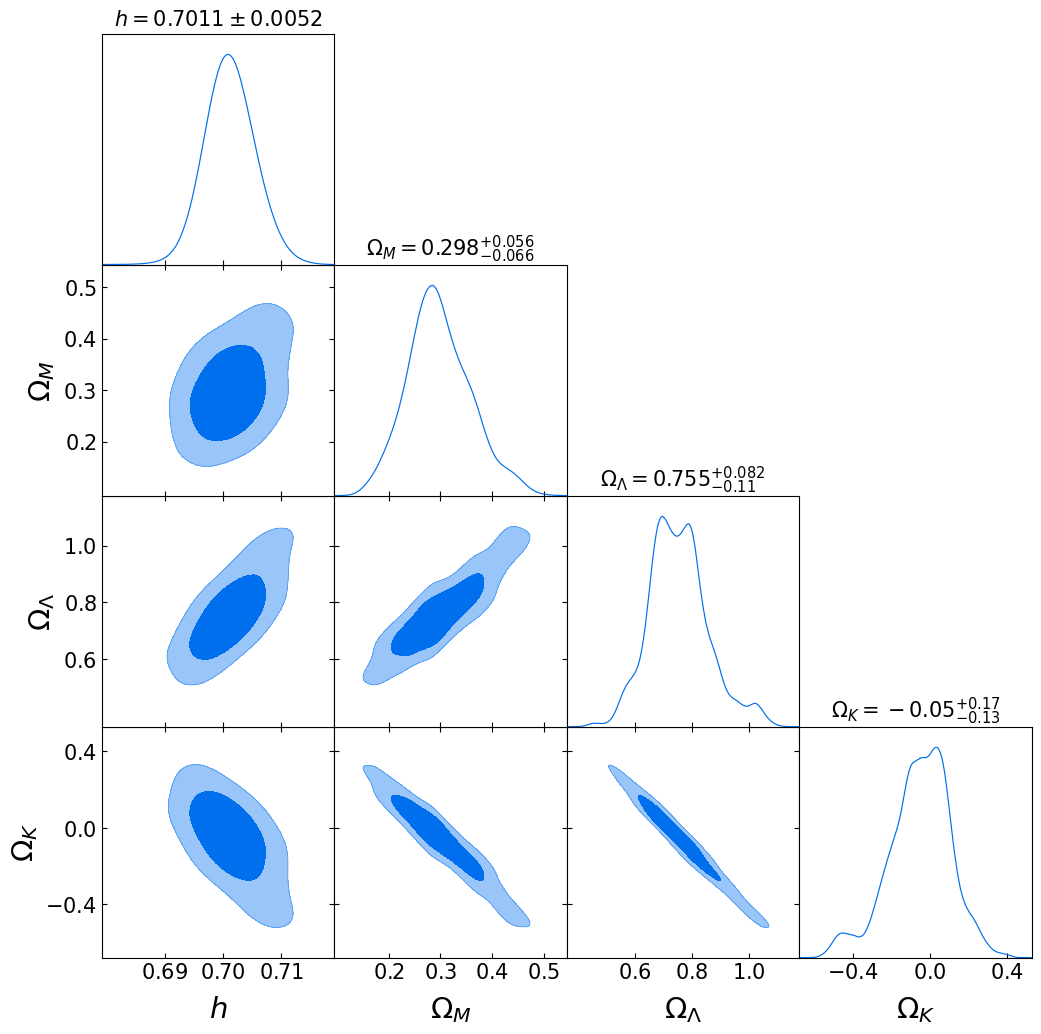

In [ ]:
# the data from Markov-chain
h = h_tot
OmegaM = Omega_M_tot
OmegaL = Omega_L_tot
# defining the omega k
OmegaK = 1. - np.add(OmegaM,OmegaL)

# defining names of variables
labels = [r'h', r'\Omega_M', r'\Omega_\Lambda', r'\Omega_K']
names = ['h', 'OmegaM', 'OmegaL', 'OmegaK']
dim = len(names) # The number of variables we're plotting

# This creates a higher-dimensional array with all our data, shaped in the appropriate way...
mysamples = np.transpose(np.reshape([h, OmegaM, OmegaL, OmegaK], (dim, len(h))))

# ... to create an "MCSamples" data type, which GetDist can use
samples = MCSamples(samples = mysamples, labels = labels, names = names)

# The 1-sigma and 3-sigma confidence level.
conf_level = 0.6827 #1 sigma
conf3_level = 0.997 #3 sigma
# This prints a table with the 1D posteriors (confidence levels)
for nam in names:
    print(round(samples.confidence(nam,(1.-conf_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples.confidence(nam,(1.-conf_level)/2.,upper=True),2),\
          " at " , int(100*conf_level),"\b% CL")
    print(round(samples.confidence(nam,(1.- conf3_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples.confidence(nam,(1.-conf3_level)/2.,upper=True),2),\
          " at " , int(100*conf3_level),"\b% CL")
print("\n")

#Triangle corner plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples, filled = True, title_limit=1)

The values of Omega Lambda are positive with a high degree of significance - I got a noble prize in my pocket!



# Spliting data into redshift bins and analysis each bin individually

In [ ]:
# redshifts goes from 0 to 1.5
# make 5 bins for redshift
zs = data.T[1] # redshift

#the bins numbered from 1 to 5 with width 0.3 ex. 1st bin is for 0<z<=0.3, 2nd for 0.3<z=<0.6 etc.
bins =np.array([0.0, 0.3, 0.6, 0.9, 1.2, 1.5])

#putting each redshift into a certain bin
zsbins = np.digitize(zs,bins, right=True)

# redshift for each bin:
zs_1 = []
zs_2 = []
zs_3 = []
zs_4 = []
zs_5 = []

# data for each redshift bin
data_1 = []
data_2 = []
data_3 = []
data_4 = []
data_5 = []

# error for each redshift bin
err_data_1 = []
err_data_2 = []
err_data_3 = []
err_data_4 = []
err_data_5 = []

# creating new redshift, data and error arrays for each redshift bin
for n in range(zs.size):
  if zsbins[n] == 1:
    zs_1.append(zs[n])
    data_1.append(mu_data[n])
    err_data_1.append(err_mu_data[n])
  elif zsbins[n] == 2:
    zs_2.append(zs[n])
    data_2.append(mu_data[n])
    err_data_2.append(err_mu_data[n])
  elif zsbins[n] == 3:
    zs_3.append(zs[n])
    data_3.append(mu_data[n])
    err_data_3.append(err_mu_data[n])
  elif zsbins[n] == 4:
    zs_4.append(zs[n])
    data_4.append(mu_data[n])
    err_data_4.append(err_mu_data[n])
  else:
    zs_5.append(zs[n])
    data_5.append(mu_data[n])
    err_data_5.append(err_mu_data[n])

# creating arrays for all redshifts, data and errors
all_zs = [zs_1, zs_2, zs_3, zs_4, zs_5]
all_data = [data_1, data_2, data_3, data_4, data_5]
all_err_data = [err_data_1, err_data_2, err_data_3, err_data_4, err_data_5]

The 5 redshift bins are as follows:
1. 0 < z <= 0.3
2. 0.3 < z <= 0.6
3. 0.6 < z <= 0.9
4. 0.9 < z <= 1.2
5. 1.2 < z <= 1.5

Acceptance rate is =  0.319030148349019
Removed no burn in
0.68  <  h  <  0.71  at  99 % CL
0.0  <  OmegaM  <  0.76  at  99 % CL
0.18  <  OmegaL  <  1.01  at  99 % CL
-0.68  <  OmegaK  <  0.8  at  99 % CL


Acceptance rate is =  0.46574449257137535
Removed no burn in
0.6  <  h  <  0.69  at  99 % CL
0.0  <  OmegaM  <  0.54  at  99 % CL
-0.51  <  OmegaL  <  0.56  at  99 % CL
-0.02  <  OmegaK  <  1.43  at  99 % CL


Acceptance rate is =  0.615991129727732
Removed no burn in
0.54  <  h  <  0.77  at  99 % CL
0.0  <  OmegaM  <  1.11  at  99 % CL
-0.06  <  OmegaL  <  0.9  at  99 % CL
-0.39  <  OmegaK  <  0.9  at  99 % CL


Acceptance rate is =  0.7377351530800442
Removed no burn in
0.44  <  h  <  0.74  at  99 % CL
0.0  <  OmegaM  <  1.6  at  99 % CL
-1.21  <  OmegaL  <  0.73  at  99 % CL
-0.44  <  OmegaK  <  1.61  at  99 % CL


Acceptance rate is =  0.8077544426494345
Removed no burn in
0.38  <  h  <  0.89  at  99 % CL
0.0  <  OmegaM  <  2.05  at  99 % CL
-0.25  <  OmegaL  <

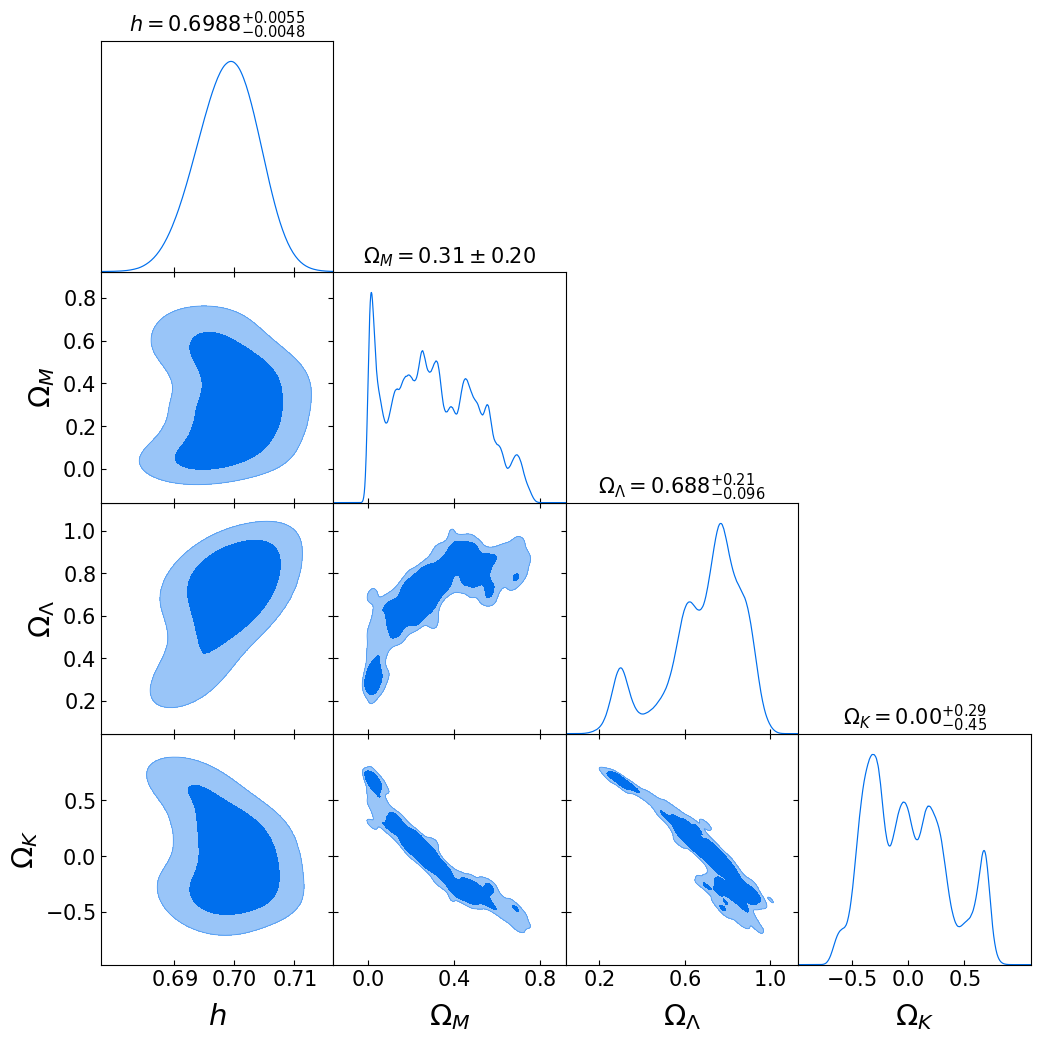

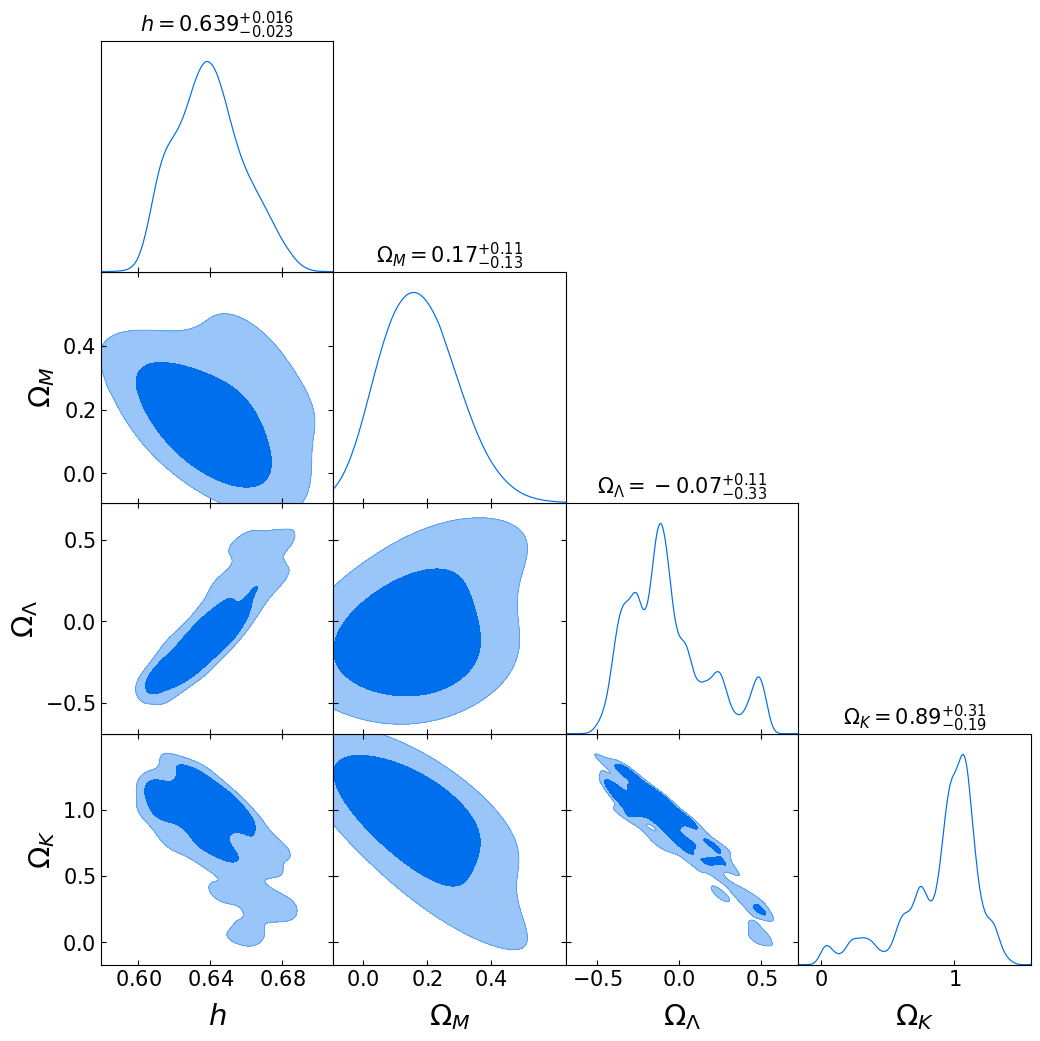

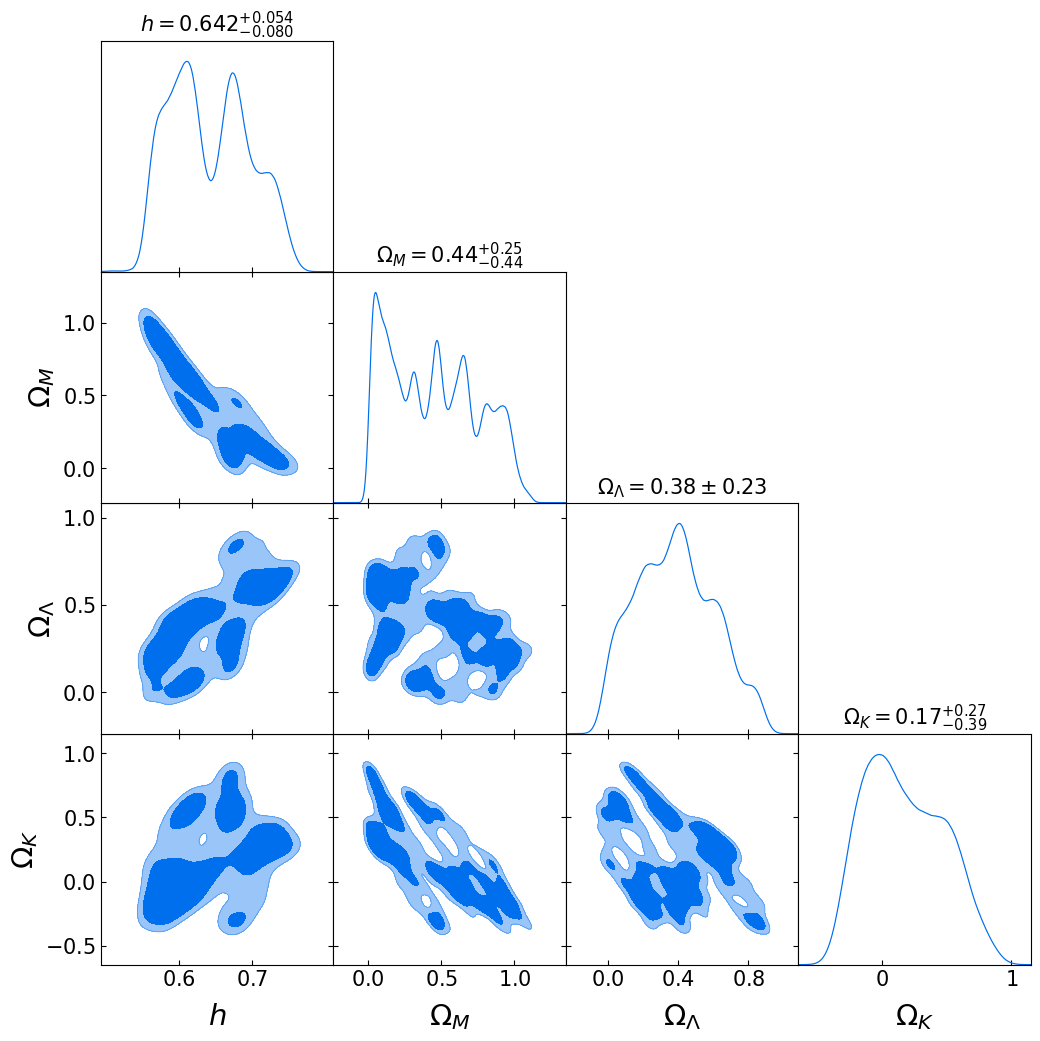

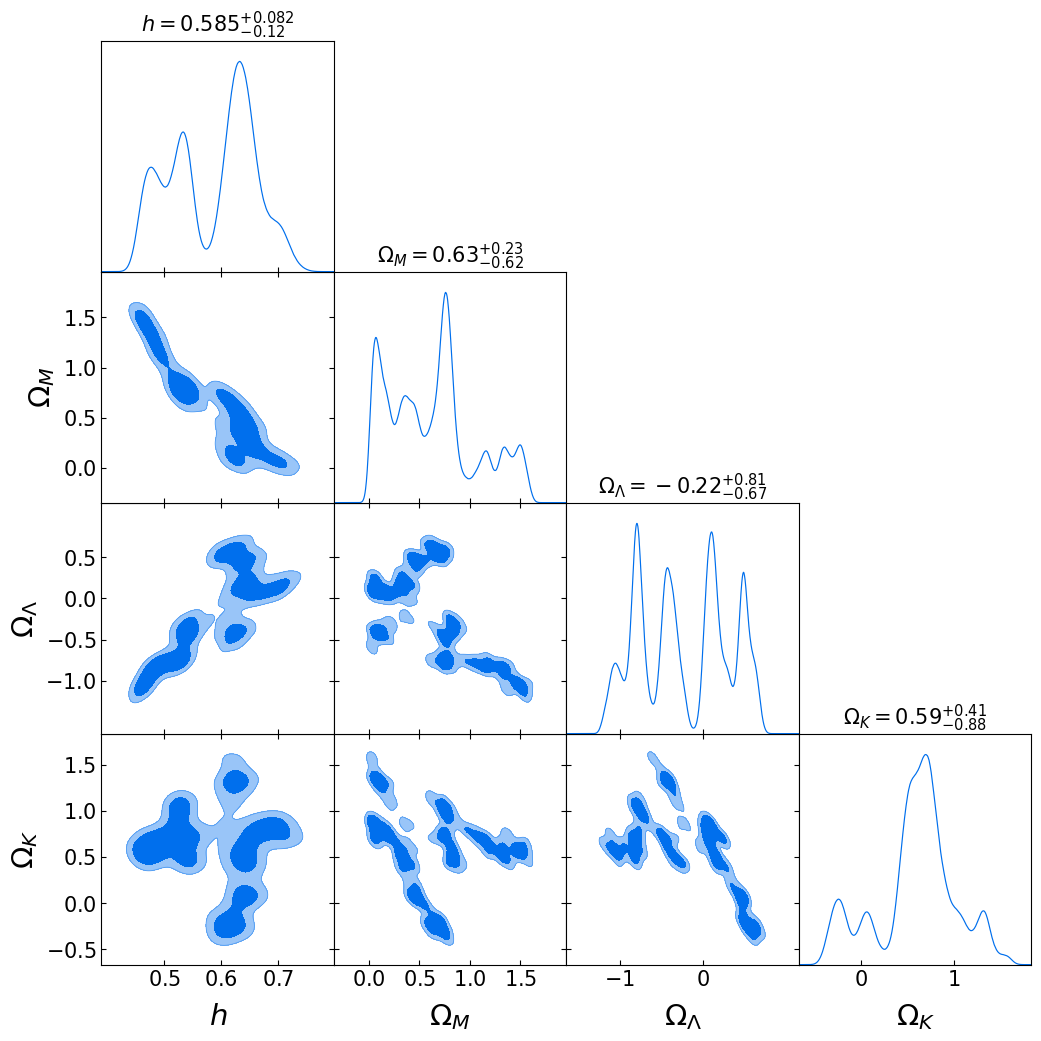

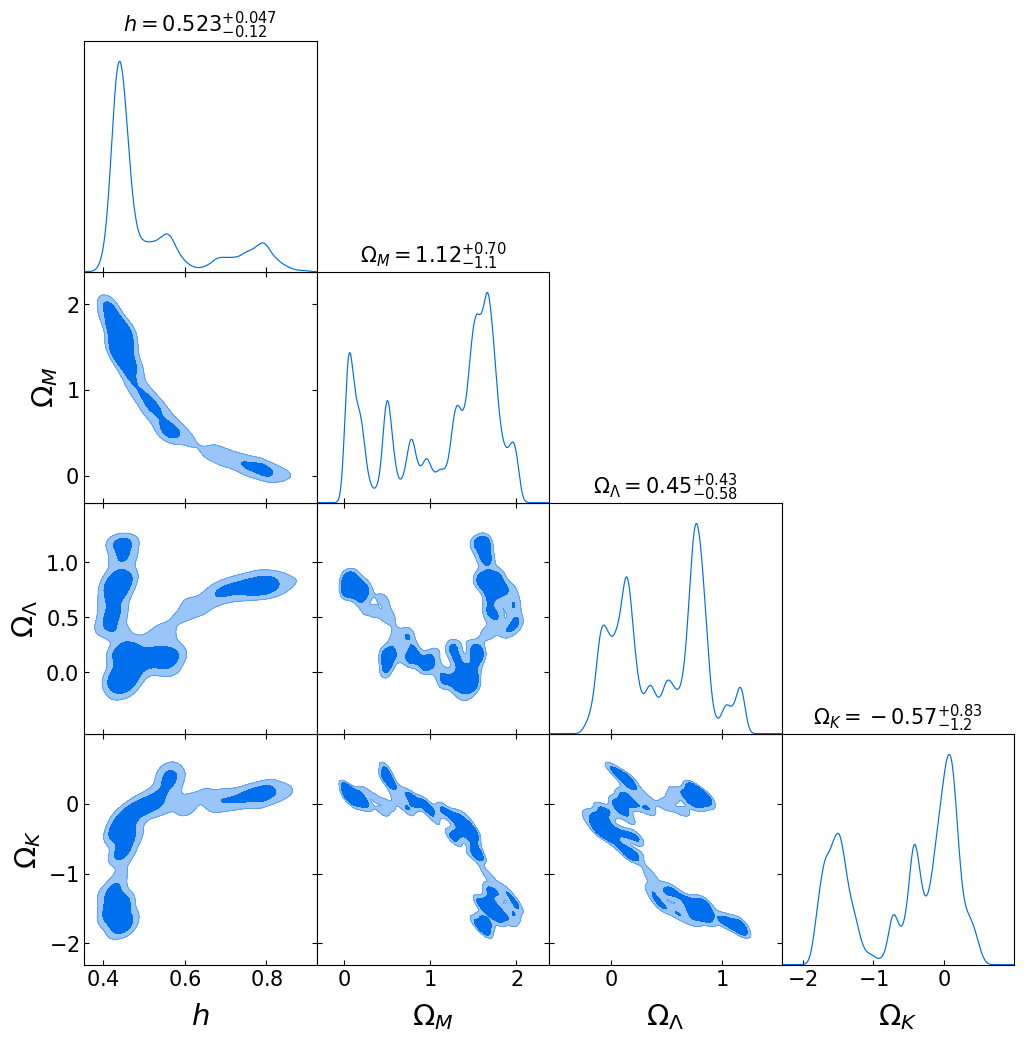

In [ ]:
import random
for j in range(5):
  # THE MARKOV-CHAIN

  # for recording the steps
  h_tot = []
  Omega_M_tot = []
  Omega_L_tot = []

  # decide the number of steps
  N = 10000

  # let's start with parameters:
  h = 0.5
  Omega_L = 0.5
  Omega_M = 0.5

  # calculate chi square for these old parameters and a varying redshift
  chi2_tot_old = 0
  for i in range(len(all_zs[j])):
    mu_mod = mu(all_zs[j][i], h, Omega_L, Omega_M)
    chi2old = (mu_mod - all_data[j][i])**2 / (all_err_data[j][i])**2
    chi2_tot_old += chi2old

  # Now for the steps and new parameters
  counter = 0
  while (True):
    # introduce new parameters with gaussian distribution steps
    h_new = h + np.random.normal(0, 0.01)
    om_M_new = Omega_M + np.random.normal(0, 0.01)
    om_L_new = Omega_L + np.random.normal(0, 0.01)

    # now calculate the chi2 for new parameters
    chi2_tot_new = 0
    for i in range(len(all_zs[j])):
      mu_mod = mu(all_zs[j][i], h_new, om_L_new, om_M_new)
      chi2new = (mu_mod - all_data[j][i])**2 / (all_err_data[j][i])**2
      chi2_tot_new += chi2new

    # introducing a random number r between 0 and 1
    r = random.uniform(0,1)

    # calculating the likelihood ratio
    # due to it usually being very big (infinity) it's set to display 2 if that happens
    Lr = np.min((2., np.exp((chi2_tot_old - chi2_tot_new)/2)))

    #make an if statement for checking r<likelihood ratio
    if (om_M_new > 0.0) and (h_new > 0.0) and r < Lr:
      h = h_new
      Omega_L = om_L_new
      Omega_M = om_M_new
      chi2_tot_old = chi2_tot_new
      counter += 1

    h_tot.append(h)
    Omega_M_tot.append(Omega_M)
    Omega_L_tot.append(Omega_L)

    if counter >= N:
      break

  #acceptance rate
  ar = N / len(h_tot)
  print("Acceptance rate is = ", ar)

  # THE GRAPHS

  # the data from Markov-chain
  h = h_tot
  OmegaM = Omega_M_tot
  OmegaL = Omega_L_tot
  # defining the omega k
  OmegaK = 1. - np.add(OmegaM,OmegaL)

  # defining names of variables
  labels = [r'h', r'\Omega_M', r'\Omega_\Lambda', r'\Omega_K']
  names = ['h', 'OmegaM', 'OmegaL', 'OmegaK']
  dim = len(names) # The number of variables we're plotting

  # This creates a higher-dimensional array with all our data, shaped in the appropriate way...
  mysamples = np.transpose(np.reshape([h, OmegaM, OmegaL, OmegaK], (dim, len(h))))

  # ... to create an "MCSamples" data type, which GetDist can use
  samples = MCSamples(samples = mysamples, labels = labels, names = names)

  # The 3-sigma confidence level
  conf3_level = 0.997 #3 sigma

  # This prints a table with the 1D posteriors (confidence levels)
  for nam in names:
    print(round(samples.confidence(nam,(1.-conf3_level)/2.,upper=False),2), \
          " < ", nam , " < ", round(samples.confidence(nam,(1.-conf3_level)/2.,upper=True),2),\
          " at " , int(100*conf3_level),"\b% CL")
  print("\n")

  #Triangle corner plot
  j = plots.getSubplotPlotter(subplot_size=3)
  j.settings.axes_labelsize = 22
  j.settings.axes_fontsize = 16
  j.triangle_plot(samples, filled = True, title_limit=1)


After graphing the data analysis for all 5 bins I can conclude that the most accurate parameter results can be seen in the bin 1, which corresponds to the redshift z between 0 and 0.3.
